# Creating annomaly plots with interannual variability between months for temperature, sea-ice, and nutrients

In [1]:
import warnings

warnings.simplefilter("ignore") # Silence warnings
import glob
from copy import deepcopy

import cartopy
import cartopy.crs as ccrs
#import hvplot.xarray
import matplotlib
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import pylab
import xarray as xr
from cartopy.util import add_cyclic_point
from matplotlib.pyplot import figure
#from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset as NetCDFFile

plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict

import cmocean
import matplotlib
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.gridspec import GridSpec

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [3]:
import re

numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Seasonality and interannual variability in SPECTRA

In [20]:
%%time
inter = '/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_monthly_yearly_1948_2009'
temp_ds_inter = xr.open_mfdataset(f'{inter}/temp_ds_inter_surface.nc');

CPU times: user 8.79 ms, sys: 3.54 ms, total: 12.3 ms
Wall time: 34.7 ms


In [21]:
%%time
## Calculate climatology for each grid cell
temp_ao_clim = np.nanmean(temp_ds_inter.TEMP,axis=0) # Size (384,320)
temp_ds = np.array(temp_ds_inter.TEMP)

CPU times: user 697 ms, sys: 1.68 s, total: 2.38 s
Wall time: 2.64 s


In [22]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
temp_arctic_anom = np.empty([62,12,384,320]) ; temp_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        temp_arctic_anom[:,:,latitude,longitude] = temp_ds[:,:,latitude,longitude]-temp_ao_clim[:,latitude,longitude]

CPU times: user 2.61 s, sys: 161 ms, total: 2.77 s
Wall time: 2.85 s


In [23]:
%%time
temp_arctic_anom_yearly = np.nanmean(temp_arctic_anom,axis=1) # size is now (62,384,320)

# Create empty arrays filled with NaN's 
pcen_90 = np.empty([384,320]) ; pcen_90[:] = np.nan
pcen_10 = np.empty([384,320]) ; pcen_10[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
    # index of array entry nearest to percentile value
        pcen_90[latitude,longitude]=np.nanpercentile(temp_arctic_anom_yearly[:,latitude,longitude],90,interpolation='nearest')
        pcen_10[latitude,longitude]=np.nanpercentile(temp_arctic_anom_yearly[:,latitude,longitude],10,interpolation='nearest')

CPU times: user 14.8 s, sys: 2.31 s, total: 17.1 s
Wall time: 27.6 s


In [24]:
%%time
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_temp_years_arctic = {}
high_temp_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_temp_years_arctic = multi_dict(2, int)
high_temp_years_arctic = multi_dict(2, int)
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_temp_years_arctic[latitude][longitude] = np.where(temp_arctic_anom_yearly[:,latitude,longitude] < pcen_10[latitude,longitude])
        high_temp_years_arctic[latitude][longitude] = np.where(temp_arctic_anom_yearly[:,latitude,longitude] > pcen_90[latitude,longitude])

CPU times: user 1.02 s, sys: 0 ns, total: 1.02 s
Wall time: 1.87 s


In [25]:
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import pop_tools

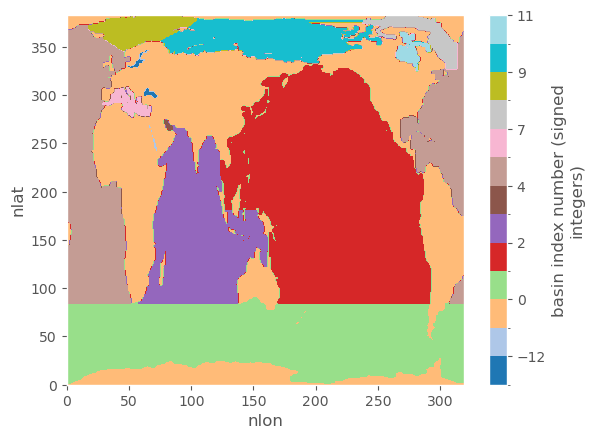

In [26]:
grid_name = 'POP_gx1v7'

dz = pop_tools.get_grid(grid_name)
regions = np.array(np.unique(dz.REGION_MASK))
regions
dz.REGION_MASK.plot.contourf(levels=regions, cmap='tab20');

In [27]:
mask3d = pop_tools.region_mask_3d(grid_name, mask_name='default')
mask3d.region

<xarray.DataArray 'region' (region: 13)>
array(['Black Sea', 'Baltic Sea', 'Red Sea', 'Southern Ocean', 'Pacific Ocean',
       'Indian Ocean', 'Persian Gulf', 'Atlantic Ocean', 'Mediterranean Sea',
       'Lab. Sea & Baffin Bay', 'GIN Seas', 'Arctic Ocean', 'Hudson Bay'],
      dtype='<U21')
Coordinates:
  * region   (region) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'

In [28]:
AO   = np.where(mask3d.sel(region='Arctic Ocean').values==1)

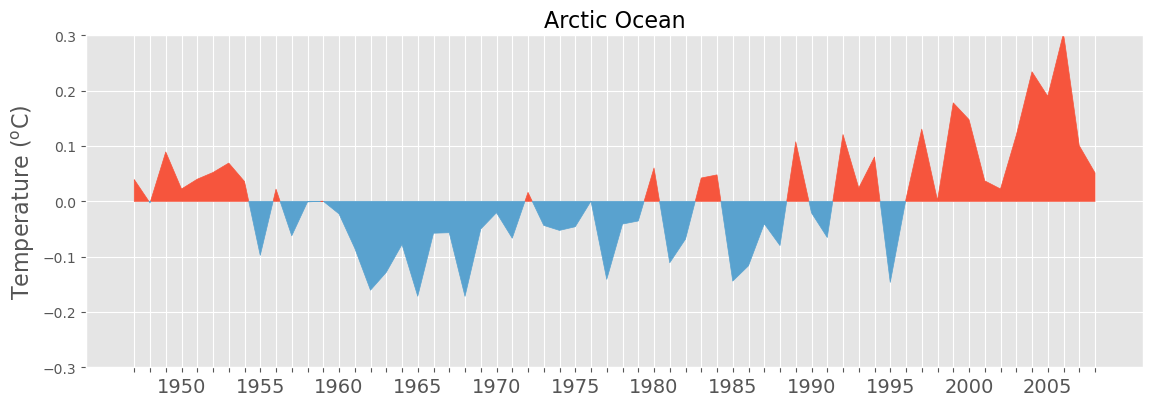

In [39]:
temp_arctic = np.nanmean(temp_arctic_anom[:,:,AO[0],AO[1]], axis=(2))
#temp_arctic_anom = temp_arctic-np.nanmean(temp_arctic,axis=0)
err_arctic = np.nanstd(temp_arctic,axis=(0,1))

plt.style.use('ggplot')

years = ['1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']
cmap= matplotlib.cm.get_cmap('Reds', 10)
cmap1= matplotlib.cm.get_cmap('Blues', 10)

fig = plt.figure(figsize=(30, 25))
gs = GridSpec(nrows=5, ncols=2)

# Subplot 1
ax1 = fig.add_subplot(gs[0, 0]);
ax1.fill_between(years, np.nanmean(temp_arctic,axis=1), where=np.nanmean(temp_arctic,axis=1)>=0, interpolate=True, color=cmap(5))
ax1.fill_between(years, np.nanmean(temp_arctic,axis=1), where=np.nanmean(temp_arctic,axis=1)<=0, interpolate=True, color=cmap1(5))
ax1.set_ylabel('Temperature ($^o$C)', fontsize=16)
ax1.set_title('Arctic Ocean', fontsize=16)
ax1.set_xticklabels(['','','','1950','','','','','1955','','','','',
                    "1960",'','','','','1965','','','','',
                    "1970",'','','','','1975','','','','',
                    "1980",'','','','','1985','','','','',
                    "1990",'','','','','1995','','','','',
                    '2000','','','','','2005','','','','2009'], fontsize=14);
ax1.set_ylim(-0.3,0.3);

In [40]:
%%time
ECOSYS_IFRAC_ds_inter = xr.open_mfdataset(f'{inter}/ECOSYS_IFRAC_ds_inter_surface.nc');

CPU times: user 14.2 ms, sys: 0 ns, total: 14.2 ms
Wall time: 40.9 ms


In [41]:
## Calculate climatology for each grid cell
ice_ao_clim = np.nanmean(ECOSYS_IFRAC_ds_inter.ECOSYS_IFRAC,axis=0) # Size (12,384,320)
ECOSYS_IFRAC_ds = np.array(ECOSYS_IFRAC_ds_inter.ECOSYS_IFRAC)

In [42]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
ice_arctic_anom = np.empty([62,12,384,320]) ; ice_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        ice_arctic_anom[:,:,latitude,longitude] = ECOSYS_IFRAC_ds[:,:,latitude,longitude]-ice_ao_clim[:,latitude,longitude]

CPU times: user 2.8 s, sys: 178 ms, total: 2.98 s
Wall time: 3.94 s


In [43]:
ice_arctic_anom_yearly = np.nanmean(ice_arctic_anom,axis=1) # size is now (62,180,360)

# Create empty arrays filled with NaN's 
pcen_90_ice = np.empty([384,320]) ; pcen_90_ice[:] = np.nan
pcen_10_ice = np.empty([384,320]) ; pcen_10_ice[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
    # index of array entry nearest to percentile value
        pcen_90_ice[latitude,longitude]=np.nanpercentile(ice_arctic_anom_yearly[:,latitude,longitude],90,interpolation='nearest')
        pcen_10_ice[latitude,longitude]=np.nanpercentile(ice_arctic_anom_yearly[:,latitude,longitude],10,interpolation='nearest')

In [44]:
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_ice_years_arctic = {}
high_ice_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_ice_years_arctic = multi_dict(2, int)
high_ice_years_arctic = multi_dict(2, int)
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_ice_years_arctic[latitude][longitude] = np.where(ice_arctic_anom_yearly[:,latitude,longitude] < pcen_10_ice[latitude,longitude])
        high_ice_years_arctic[latitude][longitude] = np.where(ice_arctic_anom_yearly[:,latitude,longitude] > pcen_90_ice[latitude,longitude])

In [45]:
%%time
NO3_ds_inter = xr.open_mfdataset(f'{inter}/NO3_ds_inter_surface.nc');

CPU times: user 5.9 ms, sys: 8.57 ms, total: 14.5 ms
Wall time: 35.5 ms


In [46]:
%%time
## Calculate climatology for each grid cell
no3_ao_clim = np.nanmean(NO3_ds_inter.NO3,axis=0) # Size (12,384,320)

CPU times: user 726 ms, sys: 3.45 s, total: 4.18 s
Wall time: 4.47 s


In [47]:
NO3_ds = np.array(NO3_ds_inter.NO3)

In [48]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
no3_arctic_anom = np.empty([62,12,384,320]) ; no3_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        no3_arctic_anom[:,:,latitude,longitude] = NO3_ds[:,:,latitude,longitude]-no3_ao_clim[:,latitude,longitude]

CPU times: user 3.1 s, sys: 614 ms, total: 3.72 s
Wall time: 3.86 s


In [49]:
%%time
no3_arctic_anom_yearly = np.nanmean(no3_arctic_anom,axis=1) # size is now (62,384,320)

# Create empty arrays filled with NaN's 
pcen_90_no3 = np.empty([384,320]) ; pcen_90_no3[:] = np.nan
pcen_10_no3 = np.empty([384,320]) ; pcen_10_no3[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
    # index of array entry nearest to percentile value
        pcen_90_no3[latitude,longitude]=np.nanpercentile(no3_arctic_anom_yearly[:,latitude,longitude],90,interpolation='nearest')
        pcen_10_no3[latitude,longitude]=np.nanpercentile(no3_arctic_anom_yearly[:,latitude,longitude],10,interpolation='nearest')

CPU times: user 14.2 s, sys: 1.55 s, total: 15.7 s
Wall time: 17.2 s


In [50]:
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_no3_years_arctic = {}
high_no3_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_no3_years_arctic = multi_dict(2, int)
high_no3_years_arctic = multi_dict(2, int)
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_no3_years_arctic[latitude][longitude] = np.where(no3_arctic_anom_yearly[:,latitude,longitude] < pcen_10_no3[latitude,longitude])
        high_no3_years_arctic[latitude][longitude] = np.where(no3_arctic_anom_yearly[:,latitude,longitude] > pcen_90_no3[latitude,longitude])

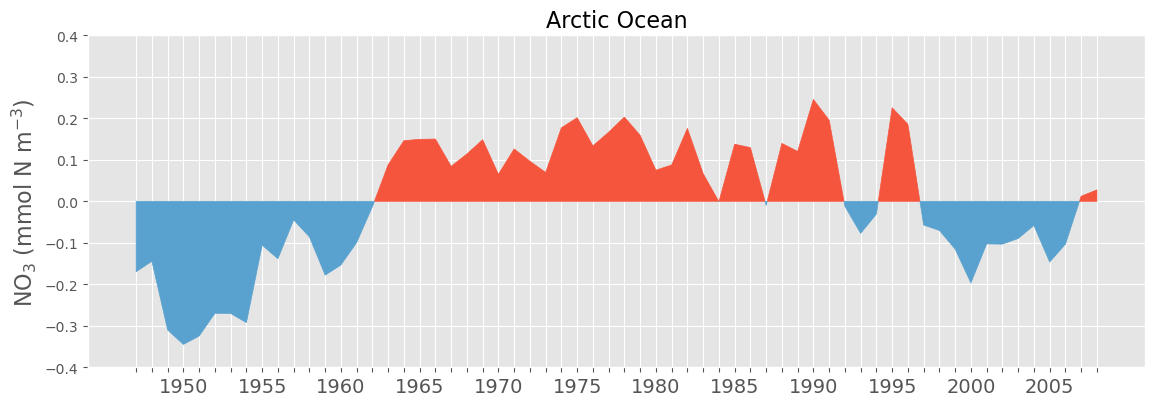

In [52]:
no3_arctic = np.nanmean(no3_arctic_anom[:,:,AO[0],AO[1]], axis=(2))

plt.style.use('ggplot')

years = ['1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']
cmap= matplotlib.cm.get_cmap('Reds', 10)
cmap1= matplotlib.cm.get_cmap('Blues', 10)

fig = plt.figure(figsize=(30, 25))
gs = GridSpec(nrows=5, ncols=2)

# Subplot 1
ax1 = fig.add_subplot(gs[0, 0]);
ax1.fill_between(years, np.nanmean(no3_arctic,axis=1), where=np.nanmean(no3_arctic,axis=1)>=0, interpolate=True, color=cmap(5))
ax1.fill_between(years, np.nanmean(no3_arctic,axis=1), where=np.nanmean(no3_arctic,axis=1)<=0, interpolate=True, color=cmap1(5))
ax1.set_ylabel('NO$_3$ (mmol N m$^{-3}$)', fontsize=16)
ax1.set_title('Arctic Ocean', fontsize=16)
ax1.set_xticklabels(['','','','1950','','','','','1955','','','','',
                    "1960",'','','','','1965','','','','',
                    "1970",'','','','','1975','','','','',
                    "1980",'','','','','1985','','','','',
                    "1990",'','','','','1995','','','','',
                    '2000','','','','','2005','','','','2009'], fontsize=14);
ax1.set_ylim(-0.4,0.4);

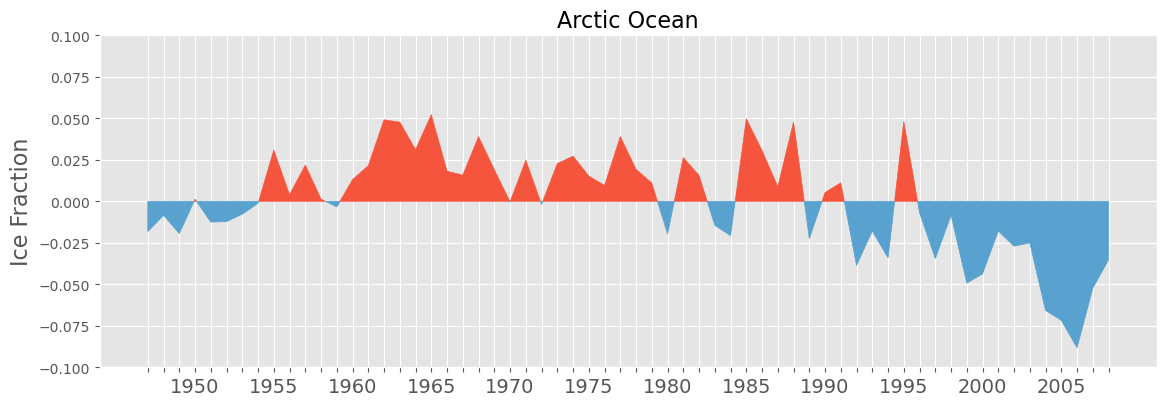

In [54]:
ice_arctic = np.nanmean(ice_arctic_anom[:,:,AO[0],AO[1]], axis=(2))

plt.style.use('ggplot')

years = ['1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']
cmap= matplotlib.cm.get_cmap('Reds', 10)
cmap1= matplotlib.cm.get_cmap('Blues', 10)

fig = plt.figure(figsize=(30, 25))
gs = GridSpec(nrows=5, ncols=2)

# Subplot 1
ax1 = fig.add_subplot(gs[0, 0]);
ax1.fill_between(years, np.nanmean(ice_arctic,axis=1), where=np.nanmean(ice_arctic,axis=1)>=0, interpolate=True, color=cmap(5))
ax1.fill_between(years, np.nanmean(ice_arctic,axis=1), where=np.nanmean(ice_arctic,axis=1)<=0, interpolate=True, color=cmap1(5))
ax1.set_ylabel('Ice Fraction', fontsize=16)
ax1.set_title('Arctic Ocean', fontsize=16)
ax1.set_xticklabels(['','','','1950','','','','','1955','','','','',
                    "1960",'','','','','1965','','','','',
                    "1970",'','','','','1975','','','','',
                    "1980",'','','','','1985','','','','',
                    "1990",'','','','','1995','','','','',
                    '2000','','','','','2005','','','','2009'], fontsize=14);
ax1.set_ylim(-0.1,0.1);